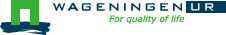



# Comparison of TAGP different natural, irrigation and fertilization conditions by PCSE
# PCSE 灌溉、施肥条件下地上干物质总量对比
This Jupyter Notebook program will show how to run PCSE to realize the comparison of LAI index growth under different natural conditions, fertigation and crop.

本Jupyter Notebook 程序将展示如何运行 PCSE 实现灌溉施肥及自然条件下作物生长时的叶面指数对比。

For details of the original procedure, see: https://github.com/ajwdewit/pcse_notebooks, Allard de Wit, April 2018

For the example we will assume that data files are in the data directory within the directory where this notebook is located. This will be the case if you downloaded the notebooks from github.

例如，我们将假设数据文件位于该 Notebook 程序所在目录的 data 数据目录中。如果您从github下载笔记本，情况就会是这样。

**Prerequisites for running this notebook**
**运行此 Notebook 程序的环境条件* *

Several packages need to be installed for running PCSE/WOFOST:

运行PCSE/WOFOST需要安装几个软件包:

  1. PCSE and its dependencies. See the [PCSE user guide](http://pcse.readthedocs.io/en/stable/installing.html) for more information;
  2. The `pandas` module for processing and storing WOFOST output;
  3. The `matplotlib` module for plotting results
  
   1.PCSE及其依赖关系。有关更多信息，请参见 [PCSE user guide](http://pcse.readthedocs.io/en/stable/installing.html)《PCSE用户指南》；
   2.`pandas` 进程和储存 WOFOST 的输出；
   3.`matplotlib`用于生成图表。


Finally, you need a working internet connection.

最后，你需要一个有效的互联网连接。

*You will see that after using LINTUL3 model, the difference between irrigation and fertilization that tried to be displayed by Panda did not appear!  !  !
*你将会看到采用LINTUL3模型后，试图用 Panda 显示的灌溉、施肥的不同并没有出现！！！

In [1]:
%matplotlib inline
import os, sys
#sys.path.append(r"D:\UserData\sources\pcse\pcse")

import matplotlib
matplotlib.style.use("ggplot")
import matplotlib.pyplot as plt
import pandas as pd
import yaml

import pcse
from pcse.models import Wofost71_WLP_FD
from pcse.fileinput import CABOFileReader, YAMLCropDataProvider
#from pcse.db import NASAPowerWeatherDataProvider
from pcse.util import WOFOST71SiteDataProvider
from pcse.base import ParameterProvider
data_dir = os.path.join(os.getcwd(), "data")

print("This notebook was built with:")
print("python version: %s " % sys.version)
print("PCSE version: %s" %  pcse.__version__)

This notebook was built with:
python version: 3.7.3 (default, Mar 27 2019, 17:13:21) [MSC v.1915 64 bit (AMD64)] 
PCSE version: 5.4.2


## Input requirements
## 输入需求

For running the PCSE/WOFOST (and PCSE models in general), you need three types of inputs:

为了 运行PCSE/LINTUL3 (以及一般的PCSE模型)，您需要三种类型的输入:

1. Model parameters that parameterize the different model components. These parameters usually
   consist of a set of crop parameters (or multiple sets in case of crop rotations), a set of soil parameters
   and a set of site parameters. The latter provide ancillary parameters that are specific for a location.
2. Driving variables represented by weather data which can be derived from various sources.
3. Agromanagement actions which specify the farm activities that will take place on the field that is simulated
   by PCSE.


1. 参数化不同模型组件的模型参数。这些参数通常包括一组作物参数，一组土壤参数和一组站点参数。后者提供特定于某个生产现场位置的参数。

2. 驱动变量由天气数据表示，天气数据可以从各种来源得到。

3. 农业事务管理活动，PCSE 指定将在模拟的田地上进行的农业活动。为了定义农业事务管理，我们将使用新的`Agromanagement`，取代以前使用的定义。

## Reading model parameters
## 读取模型参数

In this example, we will derive the model parameters from different sources. First of all, the crop parameters will be read from my [github repository](https://github.com/ajwdewit/WOFOST_crop_parameters) using the `YAMLCropDataProvider`. Next, the soil parameters will be read from a classical CABO input file using the `CABOFileReader`. Finally, the site parameters can be defined directly using the `WOFOST71SiteDataProvider` which provides sensible defaults for site parameters. 

在这个例子中，我们将从不同的来源导出模型参数。首先，将使用“YAMLCropDataProvider”从我的[github repository](https://github.com/ajwdewit/WOFOST_crop_parameters)。接下来，将使用“CABOFileReader”从经典CABO输入文件中读取土壤参数。最后，可以使用`WOFOST71SiteDataProvider`“WoFost 71站点数据提供程序”直接定义站点参数，该程序为站点参数提供了合理的默认值。

However, PCSE models expect a single set of parameters and therefore they need to be combined using the `ParameterProvider`:

然而，PCSE模型只需要一组参数，因此需要使用`ParameterProvider`“参数提供程序”进行组合:

In [2]:
crop = YAMLCropDataProvider()
soil = CABOFileReader(os.path.join(data_dir, "soil", "ec3.soil"))
site = WOFOST71SiteDataProvider(WAV=100,CO2=360)
#parameterprovider = ParameterProvider(soildata=soil, cropdata=crop, sitedata=site)

from pcse.fileinput import PCSEFileReader
#from pcse.base import ParameterProvider
#crop = PCSEFileReader(os.path.join(data_dir, "crop", "lintul3_springwheat.crop"))
#soil = PCSEFileReader(os.path.join(data_dir, "soil", "lintul3_springwheat.soil"))
#site = PCSEFileReader(os.path.join(data_dir, "site", "lintul3_springwheat.site"))
parameterprovider = ParameterProvider(soildata=soil, cropdata=crop, sitedata=site)

## Reading weather data
## 读取天气数据

For reading weather data we will use the ExcelWeatherDataProvider. 
为了读取天气数据，我们将使用 ExcelWeatherDataProvider。

In [3]:
from pcse.fileinput import ExcelWeatherDataProvider
weatherfile = os.path.join(data_dir, 'meteo', 'nl1.xlsx')
weatherdataprovider = ExcelWeatherDataProvider(weatherfile)


## 没有灌溉条件下农业事务管理事件

Defining agromanagement needs a bit more explanation because agromanagement is a relatively
complex piece of PCSE. The agromanagement definition for PCSE is written in a format called `YAML` and for a thorough discusion have a look at the [Section on Agromanagement](https://pcse.readthedocs.io/en/stable/reference_guide.html#the-agromanager) in the PCSE manual.
For the current example the agromanagement definition looks like this:

农业事务管理的定义需要更多的解释，因为农业灌溉管理是一个相对PCSE的复杂部分。pcse的农业事务管理定义是以一种称为`YAML`的格式编写的，要进行彻底的讨论，请参阅《PCSE手册》中关于农业事务管理的 [Section on Agromanagement](https://pcse.readthedocs.io/en/stable/reference_guide.html#the-agromanager)对于当前示例，农业事务管理定义如下:

    Version: 1.0
    AgroManagement:
    - 2006-01-01:
        CropCalendar:
            crop_name: sugarbeet
            variety_name: Sugarbeet_603
            crop_start_date: 2006-03-31
            crop_start_type: emergence
            crop_end_date: 2006-10-20
            crop_end_type: harvest
            max_duration: 300
        TimedEvents:null
        StateEvents: null


农业事务管理定义以 Version: “版本:”开始，表示农业事务管理文件的版本号，而实际定义从标签 AgroManagement:“农业事务管理:”后开始。接下来必须提供一个生长活动的开始日期(以及模拟的开始日期)。每个生产活动 由0或1定义 CropCalendars 、TimedEvents 和 StateEvents 一个或多个时间事件和/或状态事件。作物日历定义了作物类型、播种日期，收获日期等。而 Timed/StateEvents 定时/状态事件定义了日期或模型状态。

*注意：事件和状态中没有任何要求，说明程序在自然降雨条件下，如果有的话，模拟作物的自然生长。

在当前的例子中，生产活动从2006年1月1日开始，有一个春小麦种植日是 2006-03-31，收获日期为2006-08-20或更早，如果出现作物在此日期之前成熟的话。有关所有可能性的详细描述，请参见参考指南。

从文件中加载农业事务管理定义可以通过`YAMLAgroManagementReader` 来完成。然而，对于这个例子，我们可以在这里简单地定义它，并用YAML解析器直接解析它。在这种情况下，我们可以直接使用`Agromanagement:` “农业事务管理:”标签后的部分。

In [4]:
yaml_agro = """
- 2006-01-01:
    CropCalendar:
        crop_name: sugarbeet
        variety_name: Sugarbeet_603
        crop_start_date: 2006-03-31
        crop_start_type: emergence
        crop_end_date: 2006-10-20
        crop_end_type: harvest
        max_duration: 300
    TimedEvents:
    StateEvents: null
"""
agromanagement = yaml.load(yaml_agro)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


## Starting and running the WOFOST
## 启动和运行WOFOST
We have now all parameters, weather data and agromanagement information available to start WOFOST and make a simulation.

我们现在有了启动WOFOST和进行模拟的所有参数、天气数据和农业事务管理信息。

In [5]:
wofost = Wofost71_WLP_FD(parameterprovider, weatherdataprovider, agromanagement)
#wofost.run_till_terminate()

#from pcse.models import LINTUL3
#wofost = LINTUL3(parameterprovider, weatherdataprovider, agromanagement)
wofost.run_till_terminate()

## Getting and visualizing results
## 获取可视化结果
Next, we can easily get the output from the model using the get_output() method and turn it into a pandas DataFrame:

接下来，我们可以使用get_output()方法轻松地从模型中获得输出，并将其转换为 pandas DataFrame 熊猫数据框架:

In [6]:
import datetime
output = wofost.get_output()
#output.index("day")

#if "DVS" in output:
    #print(output["DVS"])
#print("OK")
    #print("OK")
    #print(output['day'])
#output[{'day'=}].LAI=0.022
#print(output)
df = pd.DataFrame(output).set_index("day")
#df.tail()
#df.all()


最后，我们可以用几个命令可视化 pandas 熊猫数据 “df” 框架的结果:

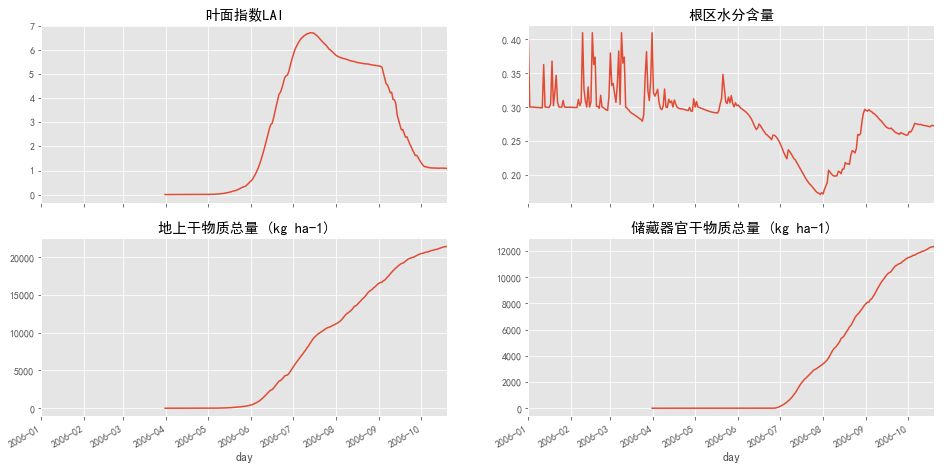

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,8))
plt.rcParams['font.serif'] = ['KaiTi']

plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

df['LAI'].plot(ax=axes[0,0], title="叶面指数LAI")
df['SM'].plot(ax=axes[0,1], title="根区水分含量")
df['TAGP'].plot(ax=axes[1,0], title="地上干物质总量 (kg ha-1)")
df['TWSO'].plot(ax=axes[1,1], title="储藏器官干物质总量 (kg ha-1)")
fig.autofmt_xdate()

# Defining agromanagement with state events
# 用生长阶段DVS状态事件定义灌溉事件
## Connecting events to development stages
## 将事件与发育阶段联系起来
It is also possible to connect irrigation events to state variables instead of dates. A logical approach is to connect an irrigation even to a development stage instead of a date, in this way changes in the sowing date will be automatically reflected in changes in irrigation events.

也可以将灌溉事件与状态变量而不是日期联系起来。一种合乎逻辑的方法是将灌溉连到生育发展阶段而不是日期，这样播种日期的变化将自动反映在灌溉事件的变化中。

For this we need to change the definition of the agromanagement as below:

为此，我们需要改变农业事务管理的数据定义如下:

    Version: 1.0
    AgroManagement:
    - 2006-01-01:
        CropCalendar:
            crop_name: sugarbeet
            variety_name: Sugarbeet_603
            crop_start_type: emergence
            crop_end_date: 2006-10-20
            crop_end_type: harvest
            max_duration: 300
        TimedEvents: null
        StateEvents:
        -   event_signal: irrigate
            event_state: DVS
            zero_condition: rising
            name: Irrigation application table
            comment: All irrigation amounts in cm
            events_table:
            - 0.9: {amount: 10, efficiency: 0.7}
            - 1.5: {amount:  5, efficiency: 0.7}
    - 2006-11-20: null
       
In this case the irrigation events are connected to the state DVS and are occurring when the simulated DVS crosses the values 0.9 and 1.5. Note that there two additional parameters: `event_state` which defines the state to which the event is connected and `zero_condition` which specifies the condition under which the state event fires, see for an explanation [here](http://pcse.readthedocs.org/en/latest/code.html#agromanagement). Finally, also note that there must be an "empty trailing campaign" defined which defines that the campaign that starts at 2006-01-01 ends at 2006-11-20. Otherwise PCSE cannot determine the end of the simulation period, see also the link above for an explanation.

在这种情况下，灌溉事件与 DVS 有关，并且在模拟 DVS 跨越0.9和1.5的值时发生。请注意，还有两个附加参数: `event_state`“事件状态”定义了事件连接的状态， `zero_condition` 指定了状态事件触发的条件，请参见此处的[here](http://pcse.readthedocs.org/en/latest/code.html#agromanagement) 解释。最后，还要注意，必须定义一个"empty trailing campaign" 空的跟踪活动，它定义了从2006-01-01开始的活动在2006-11-20结束。否则，PCSE无法确定模拟周期的结束，请参见上面的链接以获得解释。

**The irrigation event NAME: Irrigation application table is driven by the event_state: DVS state event. When DVS is less than or equal to 0.9, the irrigation event is started, and the amount of supplementary irrigation is 10 cm. The efficient of irrigation water is 0.7.  When DVS is less than or equal to 1.5, the irrigation amount is 5 cm, and the efficient of irrigation water is 0.7.

**灌溉事件 name: Irrigation application table 的灌水时间由 event_state: DVS 状态事件驱动，当 DVS 小于等于0.9 时，灌水事件启动，补充灌水量为：10 cm　灌溉水利用率为：0.7；当 DVS 小于等于1.5 时 灌溉量为：5 cm　灌溉水利用率为：0.7。


Again, we will define the agromanagement directly on the command line and parse it with YAML.
同样，我们将直接在命令行上定义农业事务管理，并用YAML解析它。

In [8]:
yaml_agro = """
- 2006-01-01:
    CropCalendar:
        crop_name: sugarbeet
        variety_name: Sugarbeet_603
        crop_start_date: 2006-03-31
        crop_start_type: emergence
        crop_end_date: 2006-10-20
        crop_end_type: harvest
        max_duration: 300
    TimedEvents: null
    StateEvents:
    -   event_signal: irrigate
        event_state: DVS
        zero_condition: rising
        name: Irrigation application table
        comment: All irrigation amounts in cm
        events_table:
        - 0.2: {amount: 10, efficiency: 0.7}
        - 0.6: {amount:  1, efficiency: 0.7}
- 2006-11-20: null
"""
agromanagement = yaml.load(yaml_agro)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


Again we run the model with all inputs but a changed agromanagement and plot the results

我们再次使用除了改变的农业事务管理以外的所有输入运行模型，并绘图“df2”的输出结果

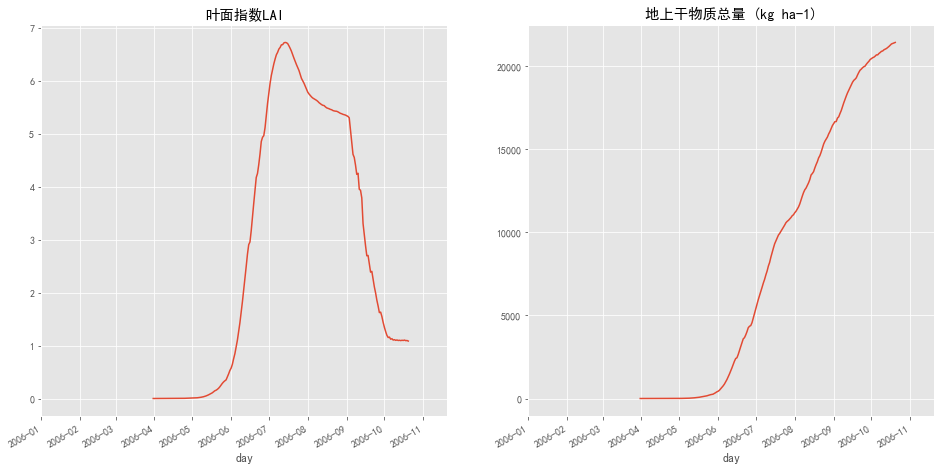

In [9]:
wofost2 = Wofost71_WLP_FD(parameterprovider, weatherdataprovider, agromanagement)
#wofost2.run_till_terminate()

#wofost2 = LINTUL3(parameterprovider, weatherdataprovider, agromanagement)
wofost2.run_till_terminate()

output2 = wofost2.get_output()
df2 = pd.DataFrame(output2).set_index("day")
fig2, axes2 = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
#plt.rcParams['font.sans-serif'] = ['KaiTi']
plt.rcParams['font.serif'] = ['KaiTi']

plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

df2['LAI'].plot(ax=axes2[0], title="叶面指数LAI")
df2['TAGP'].plot(ax=axes2[1], title="地上干物质总量 (kg ha-1)")
fig2.autofmt_xdate()

## Connecting  events to soil moisture levels
## 将状态与施肥量联系起来
The logical approach is to connect irrigation events to stress levels that are experiences by the crop. In this case we connect the irrigation event to the state variables soil moisture (DVS) and define the agromanagement like this:

合乎逻辑的方法是将DVS与施肥联系起来。在这种情况下，我们将施肥与DVS状态变量联系起来，并定义如下的农业事务管理:

    Version: 1.0
    AgroManagement:
    - 2006-01-01:
        CropCalendar:
            crop_name: sugarbeet
            variety_name: Sugarbeet_603
            crop_start_date: 2006-03-31
            crop_start_type: emergence
            crop_end_date: 2006-10-20
            crop_end_type: harvest
            max_duration: 300
        TimedEvents: null
        StateEvents:
        -   event_signal: apply_npk
        event_state: DVS
        zero_condition: rising
        name: DVS-based N/P/K application table
        comment: all fertilizer amounts in kg/ha
        events_table:
        - 0.3: {N_amount : 1, P_amount: 3, K_amount: 4}
        - 0.6: {N_amount: 11, P_amount: 13, K_amount: 14}
        - 1.12: {N_amount: 21, P_amount: 23, K_amount: 24}
    - 2006-11-20:
    
Note that in this case the `zero_condition` is `rising` because we only want the event to trigger when the DVS goes up the specified level (0.3).

*Note, When DVS=0.3, N_amount : 1, P_amount: 3, K_amount: 4；DVS为0.6时，N_amount: 11, P_amount: 13, K_amount: 14；DVS=1.12时，N_amount: 21, P_amount: 23, K_amount: 24。

*请注意，在DVS是0.3时施肥量 N_amount : 1, P_amount: 3, K_amount: 4；DVS为0.6时，N_amount: 11, P_amount: 13, K_amount: 14；DVS=1.12时，N_amount: 21, P_amount: 23, K_amount: 24。

In [10]:
yaml_agro = """
- 2006-01-01:
    CropCalendar:
        crop_name: sugarbeet
        variety_name: Sugarbeet_603
        crop_start_date: 2006-03-31
        crop_start_type: emergence
        crop_end_date: 2006-10-20
        crop_end_type: harvest
        max_duration: 300
    TimedEvents: null
    StateEvents:
    -   event_signal: apply_npk
        event_state: DVS
        zero_condition: rising
        name: DVS-based N/P/K application table
        comment: all fertilizer amounts in kg/ha
        events_table:
        - 0.3: {N_amount : 1, P_amount: 3, K_amount: 4}
        - 0.6: {N_amount: 11, P_amount: 13, K_amount: 14}
        - 1.12: {N_amount: 21, P_amount: 23, K_amount: 24}
- 2006-11-20: null
"""
agromanagement = yaml.load(yaml_agro)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


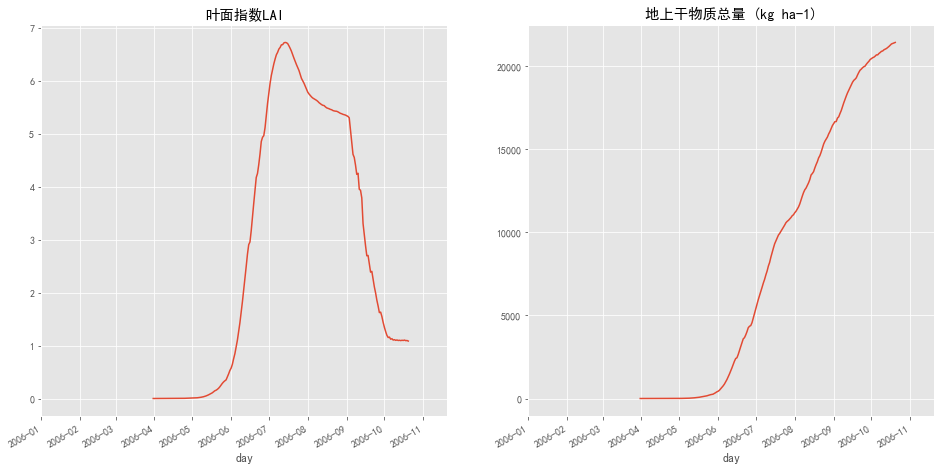

In [11]:
wofost3 = Wofost71_WLP_FD(parameterprovider, weatherdataprovider, agromanagement)
#wofost3.run_till_terminate()

#wofost3 = LINTUL3(parameterprovider, weatherdataprovider, agromanagement)
wofost3.run_till_terminate()

output3 = wofost3.get_output()
df3 = pd.DataFrame(output3).set_index("day")

fig3, axes3 = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
#plt.rcParams['font.sans-serif'] = ['KaiTi']
plt.rcParams['font.serif'] = ['KaiTi']

plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

df3['LAI'].plot(ax=axes3[0], title="叶面指数LAI")
df3['TAGP'].plot(ax=axes3[1], title="地上干物质总量 (kg ha-1)")
fig3.autofmt_xdate()

Showing the differences in irrigation events
============================================
显示灌溉、施肥不同事件与自然种植条件的对比
============================================
We combine the `SM`  column from the different data frames in a new dataframe and plot the results to see the effect of the differences in agromanagement.

我们将不同数据框架中的`SM` 列合并到一个新的数据框架中，并绘制图形结果，以查看农业事务管理中差异的影响。

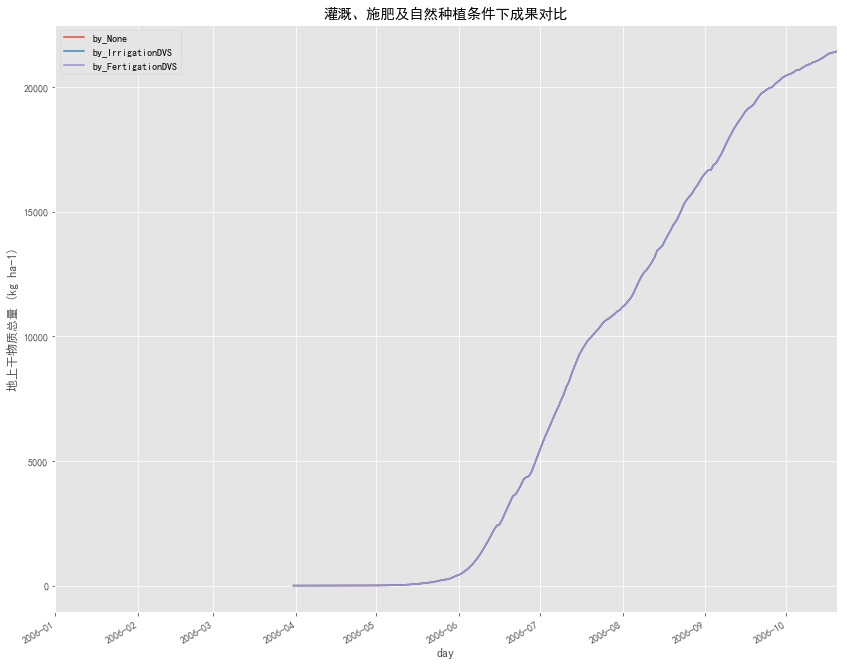

In [12]:
df_all = pd.DataFrame({"by_None": df.TAGP, 
                       "by_IrrigationDVS": df2.TAGP, 
                       "by_FertigationDVS": df3.TAGP}, index=df.index)
fig4, axes4 = plt.subplots(nrows=1, ncols=1, figsize=(14,12))

#plt.rcParams['font.sans-serif'] = ['KaiTi']
plt.rcParams['font.serif'] = ['KaiTi']

plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号


df_all.plot(ax=axes4, title="灌溉、施肥及自然种植条件下成果对比")
#axes4.set_ylabel("叶面积指数LAI")

axes4.set_ylabel("地上干物质总量 (kg ha-1)")

fig4.autofmt_xdate()